In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==================== Seed Setting ====================
def set_seed(seed=1443):
    """Set seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True


# ==================== Dataset Class with One-Hot Encoding ====================
class CustomDataset(Dataset):
    """Custom Dataset with one-hot encoded labels"""

    def __init__(self, features, labels, num_classes=3):
        self.features = torch.FloatTensor(features)
        self.labels_int = torch.LongTensor(labels)  # Keep integer labels for evaluation
        # Create one-hot encoded labels
        self.labels_onehot = F.one_hot(self.labels_int, num_classes=num_classes).float()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return both integer and one-hot labels
        return self.features[idx], self.labels_int[idx], self.labels_onehot[idx]


# ==================== Neural Network Model ====================
class MultiClassNN(nn.Module):
    """
    Neural Network Architecture:
    - Input: 2 neurons
    - Hidden Layer 1: 4 neurons + ReLU
    - Hidden Layer 2: 4 neurons + ReLU
    - Output: 3 neurons + Softmax
    """

    def __init__(self):
        super(MultiClassNN, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(2, 4)  # W1: R^(2x4)
        self.fc2 = nn.Linear(4, 4)  # W2: R^(4x4)
        self.fc3 = nn.Linear(4, 3)  # W3: R^(4x3)
        self.relu = nn.ReLU()

        # Initialize weights with Kaiming Uniform
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming Uniform initialization"""
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="relu")

        # Initialize biases to zero
        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)
        if self.fc3.bias is not None:
            nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        """Forward pass through the network returning logits"""
        x = self.relu(self.fc1(x))  # Hidden layer 1
        x = self.relu(self.fc2(x))  # Hidden layer 2
        x = self.fc3(x)  # Output layer (logits)
        return x


# ==================== Cross Entropy Loss with One-Hot Encoding ====================
def cross_entropy_loss_onehot(predictions, targets_onehot):
    """
    Compute cross-entropy loss with one-hot encoded targets

    Formula: L = -sum(y_true * log(softmax(y_pred)))

    Args:
        predictions: Raw logits from model (batch_size, num_classes)
        targets_onehot: One-hot encoded labels (batch_size, num_classes)

    Returns:
        loss: Cross-entropy loss (scalar)
    """
    # Apply log-softmax to predictions for numerical stability
    log_probs = F.log_softmax(predictions, dim=1)

    # Compute cross-entropy: -sum(target * log(pred)) for each sample
    loss = -torch.sum(targets_onehot * log_probs, dim=1)

    # Return mean loss over batch
    return torch.mean(loss)


# ==================== Training Function ====================
def train_model(model, train_loader, optimizer, device, epochs=100):
    """
    Train the neural network using one-hot encoded labels

    Returns:
        loss_history: List of average training losses per epoch
    """
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_features, _, batch_labels_onehot in train_loader:
            # Move data to device
            batch_features = batch_features.to(device)
            batch_labels_onehot = batch_labels_onehot.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass (get logits)
            outputs = model(batch_features)

            # Compute cross-entropy loss with one-hot encoded labels
            loss = cross_entropy_loss_onehot(outputs, batch_labels_onehot)

            # Backward pass
            loss.backward()

            # Update weights using SGD
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        # Calculate average loss for the epoch
        avg_loss = epoch_loss / num_batches
        loss_history.append(avg_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

    return loss_history


# ==================== Testing Function ====================
def test_model(model, test_loader, device):
    """
    Test the neural network and compute accuracy

    Returns:
        accuracy: Testing accuracy (%)
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_features, batch_labels_int, _ in test_loader:
            batch_features = batch_features.to(device)
            batch_labels_int = batch_labels_int.to(device)

            # Forward pass (get logits)
            outputs = model(batch_features)

            # Get predictions (argmax of logits)
            _, predicted = torch.max(outputs.data, 1)

            total += batch_labels_int.size(0)
            correct += (predicted == batch_labels_int).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# ==================== Data Loading Function ====================
def load_data(train_path="train_q4.csv", test_path="test_q4.csv"):
    """
    Load training and testing data from CSV files
    Assumes: First columns are features, last column is label
    """
    # Load CSV files
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values
    y_train = train_df.iloc[:, -1].values

    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    # Convert labels to 0-indexed if necessary
    unique_labels = np.unique(np.concatenate([y_train, y_test]))
    if not np.array_equal(unique_labels, np.arange(len(unique_labels))):
        label_mapping = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        y_train = np.array([label_mapping[label] for label in y_train])
        y_test = np.array([label_mapping[label] for label in y_test])
        print(f"Label mapping applied: {label_mapping}")

    return X_train, y_train, X_test, y_test


# ==================== Main Execution ====================
def main():
    # Configuration
    seed = 1443
    batch_size = 256
    epochs = 100
    learning_rates = [0.4, 0.1, 0.001]

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Using one-hot encoding for labels")
    print(f"Optimizer: SGD")
    print(f"Loss Function: Cross-Entropy Loss")
    print(f"Batch Size: {batch_size}")
    print(f"Training Epochs: {epochs}")

    # Load data
    print("\n" + "=" * 60)
    print("Loading data...")
    print("=" * 60)
    X_train, y_train, X_test, y_test = load_data("train_q4.csv", "test_q4.csv")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Feature dimension: {X_train.shape[1]}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    # Create datasets with one-hot encoding
    num_classes = len(np.unique(y_train))
    train_dataset = CustomDataset(X_train, y_train, num_classes=num_classes)
    test_dataset = CustomDataset(X_test, y_test, num_classes=num_classes)

    # Verify one-hot encoding
    sample_feature, sample_int, sample_onehot = train_dataset[0]
    print(f"\nSample verification:")
    print(f"  Feature shape: {sample_feature.shape}")
    print(f"  Integer label: {sample_int.item()}")
    print(f"  One-hot label: {sample_onehot.numpy()}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Store results for each learning rate
    results = {}

    # Train with different learning rates
    for lr in learning_rates:
        print(f"\n{'=' * 60}")
        print(f"Training with Learning Rate: {lr}")
        print(f"{'=' * 60}")

        # Set seed for reproducibility
        set_seed(seed)

        # Initialize model
        model = MultiClassNN().to(device)

        # Print model architecture
        if lr == learning_rates[0]:  # Print only once
            print(f"\nModel Architecture:")
            print(model)
            print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

        # Initialize optimizer (SGD)
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Train model
        loss_history = train_model(model, train_loader, optimizer, device, epochs)

        # Test model
        accuracy = test_model(model, test_loader, device)

        # Store results
        results[lr] = {
            "loss_history": loss_history,
            "accuracy": accuracy,
            "model": model,
        }

        print(f"\nTest Accuracy with LR={lr}: {accuracy:.2f}%")

    # ==================== Visualization ====================
    print(f"\n{'=' * 60}")
    print("Generating Plots...")
    print(f"{'=' * 60}")

    # Plot training loss curves
    plt.figure(figsize=(14, 5))

    # Subplot 1: Training Loss Curves
    plt.subplot(1, 2, 1)
    colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]
    for idx, lr in enumerate(learning_rates):
        plt.plot(
            range(1, epochs + 1),
            results[lr]["loss_history"],
            label=f"LR={lr}",
            linewidth=2,
            color=colors[idx],
        )
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Training Loss (Cross-Entropy)", fontsize=12)
    plt.title(
        "Training Loss vs Epoch (One-Hot Encoding)", fontsize=14, fontweight="bold"
    )
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Subplot 2: Test Accuracy Comparison
    plt.subplot(1, 2, 2)
    accuracies = [results[lr]["accuracy"] for lr in learning_rates]
    bars = plt.bar(
        [str(lr) for lr in learning_rates],
        accuracies,
        color=colors,
        alpha=0.8,
        edgecolor="black",
        linewidth=1.5,
    )
    plt.xlabel("Learning Rate", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.title("Test Accuracy Comparison", fontsize=14, fontweight="bold")
    plt.ylim([0, 100])

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.savefig("training_results.png", dpi=300, bbox_inches="tight")
    print("Plot saved as: training_results.png")
    plt.show()

    # ==================== Summary Report ====================
    print(f"\n{'=' * 60}")
    print("SUMMARY REPORT")
    print(f"{'=' * 60}")
    print(f"{'Learning Rate':<20} {'Test Accuracy':<20} {'Final Loss':<20}")
    print(f"{'-' * 60}")
    for lr in learning_rates:
        final_loss = results[lr]["loss_history"][-1]
        accuracy = results[lr]["accuracy"]
        print(f"{lr:<20} {accuracy:<20.2f}% {final_loss:<20.4f}")

    # Find best learning rate
    best_lr = max(learning_rates, key=lambda lr: results[lr]["accuracy"])
    best_accuracy = results[best_lr]["accuracy"]
    worst_lr = min(learning_rates, key=lambda lr: results[lr]["accuracy"])
    worst_accuracy = results[worst_lr]["accuracy"]

    print(f"\n{'=' * 60}")
    print("ANALYSIS AND FINDINGS")
    print(f"{'=' * 60}")

    print(f"\n1. BEST CONFIGURATION:")
    print(f"   Learning Rate: {best_lr}")
    print(f"   Test Accuracy: {best_accuracy:.2f}%")
    print(f"   Final Training Loss: {results[best_lr]['loss_history'][-1]:.4f}")

    print(f"\n2. LEARNING RATE ANALYSIS:")
    for lr in learning_rates:
        loss_history = results[lr]["loss_history"]
        accuracy = results[lr]["accuracy"]
        initial_loss = loss_history[0]
        final_loss = loss_history[-1]
        loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100

        print(f"\n   LR = {lr}:")
        print(f"   - Initial Loss: {initial_loss:.4f}")
        print(f"   - Final Loss: {final_loss:.4f}")
        print(f"   - Loss Reduction: {loss_reduction:.2f}%")
        print(f"   - Test Accuracy: {accuracy:.2f}%")

        # Convergence analysis
        last_10_avg = np.mean(loss_history[-10:])
        prev_10_avg = (
            np.mean(loss_history[-20:-10])
            if len(loss_history) >= 20
            else loss_history[0]
        )

        if abs(last_10_avg - prev_10_avg) < 0.01:
            print(f"   - Status: Converged ✓")
        else:
            print(f"   - Status: Still improving (may benefit from more epochs)")

    print(f"\n3. COMPARATIVE INSIGHTS:")
    print(f"   - Accuracy Range: {worst_accuracy:.2f}% - {best_accuracy:.2f}%")
    print(f"   - Accuracy Spread: {best_accuracy - worst_accuracy:.2f}%")

    if best_lr == 0.4:
        print(
            f"   - High LR (0.4) performs best: Fast convergence with good generalization"
        )
    elif best_lr == 0.1:
        print(f"   - Medium LR (0.1) performs best: Balanced convergence and stability")
    elif best_lr == 0.001:
        print(f"   - Low LR (0.001) performs best: Slow but stable convergence")

    print(f"\n4. IMPLEMENTATION DETAILS:")
    print(f"   - One-hot encoding: Enabled ✓")
    print(f"   - Loss function: Cross-Entropy with one-hot targets")
    print(f"   - Optimizer: SGD")
    print(f"   - Weight initialization: Kaiming Uniform")
    print(f"   - Seed: {seed} (for reproducibility)")

    print(f"\n{'=' * 60}\n")

Using device: cuda
Using one-hot encoding for labels
Optimizer: SGD
Loss Function: Cross-Entropy Loss
Batch Size: 256
Training Epochs: 100

Loading data...
Training samples: 8000
Testing samples: 2000
Feature dimension: 2
Number of classes: 3

Sample verification:
  Feature shape: torch.Size([2])
  Integer label: 1
  One-hot label: [0. 1. 0.]

Training with Learning Rate: 0.4

Model Architecture:
MultiClassNN(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=3, bias=True)
  (relu): ReLU()
)

Total parameters: 47
Epoch [10/100], Loss: 0.1749
Epoch [20/100], Loss: 0.1913
Epoch [30/100], Loss: 1.0012
Epoch [40/100], Loss: 0.6718
Epoch [50/100], Loss: 0.6688
Epoch [60/100], Loss: 0.6681
Epoch [70/100], Loss: 0.6712
Epoch [80/100], Loss: 0.6687
Epoch [90/100], Loss: 0.6664
Epoch [100/100], Loss: 0.6660

Test Accuracy with LR=0.4: 57.50%

Training with Learning Rate: 0.1
Epoch [10/1

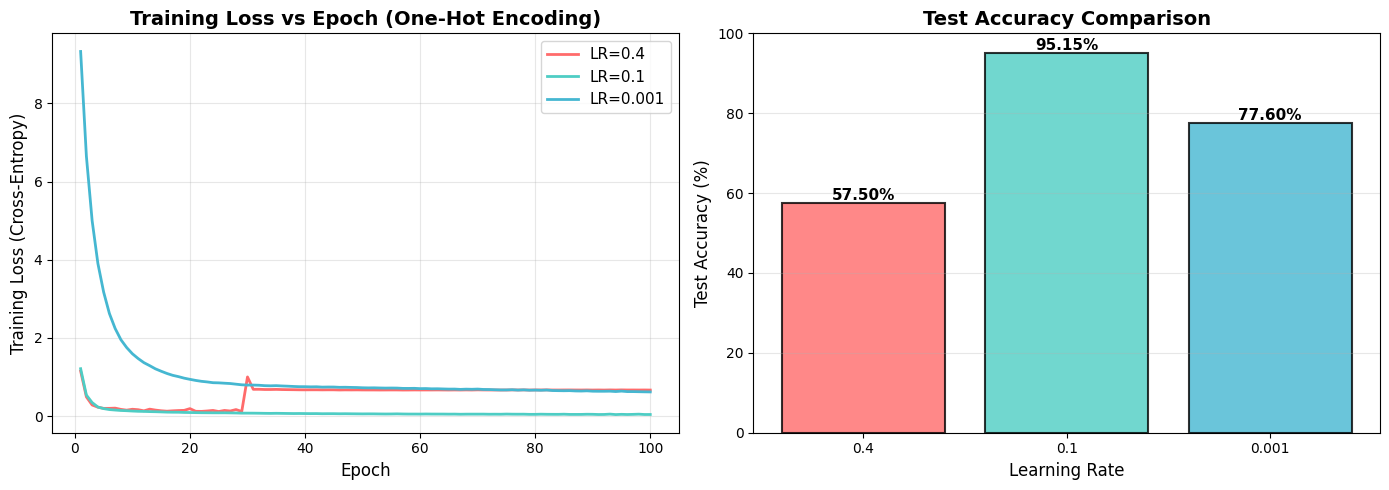


SUMMARY REPORT
Learning Rate        Test Accuracy        Final Loss          
------------------------------------------------------------
0.4                  57.50               % 0.6660              
0.1                  95.15               % 0.0410              
0.001                77.60               % 0.6183              

ANALYSIS AND FINDINGS

1. BEST CONFIGURATION:
   Learning Rate: 0.1
   Test Accuracy: 95.15%
   Final Training Loss: 0.0410

2. LEARNING RATE ANALYSIS:

   LR = 0.4:
   - Initial Loss: 1.1524
   - Final Loss: 0.6660
   - Loss Reduction: 42.21%
   - Test Accuracy: 57.50%
   - Status: Converged ✓

   LR = 0.1:
   - Initial Loss: 1.2120
   - Final Loss: 0.0410
   - Loss Reduction: 96.61%
   - Test Accuracy: 95.15%
   - Status: Converged ✓

   LR = 0.001:
   - Initial Loss: 9.3253
   - Final Loss: 0.6183
   - Loss Reduction: 93.37%
   - Test Accuracy: 77.60%
   - Status: Still improving (may benefit from more epochs)

3. COMPARATIVE INSIGHTS:
   - Accuracy Range:

In [2]:
main()

In [7]:
# ==================== Base Neural Network (No Custom Initialization) ====================
class MultiClassNN_Base(nn.Module):
    """
    Base Neural Network with PyTorch default initialization
    Architecture: 2 -> 4 -> 4 -> 3
    """

    def __init__(self):
        super(MultiClassNN_Base, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        # No custom initialization - uses PyTorch default

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Xavier Uniform Initialization ====================
class MultiClassNN_XavierUniform(nn.Module):
    """
    Neural Network with Xavier Uniform initialization
    Good for: Sigmoid, Tanh activations (but we'll test with ReLU)
    """

    def __init__(self):
        super(MultiClassNN_XavierUniform, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Xavier Normal Initialization ====================
class MultiClassNN_XavierNormal(nn.Module):
    """
    Neural Network with Xavier Normal initialization
    Good for: Sigmoid, Tanh activations
    """

    def __init__(self):
        super(MultiClassNN_XavierNormal, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Kaiming Uniform Initialization ====================
class MultiClassNN_KaimingUniform(nn.Module):
    """
    Neural Network with Kaiming Uniform initialization (He initialization)
    Good for: ReLU activations
    """

    def __init__(self):
        super(MultiClassNN_KaimingUniform, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity="relu")
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Kaiming Normal Initialization ====================
class MultiClassNN_KaimingNormal(nn.Module):
    """
    Neural Network with Kaiming Normal initialization (He initialization)
    Good for: ReLU activations
    """

    def __init__(self):
        super(MultiClassNN_KaimingNormal, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Orthogonal Initialization ====================
class MultiClassNN_Orthogonal(nn.Module):
    """
    Neural Network with Orthogonal initialization
    Good for: Deep networks, helps with gradient flow
    """

    def __init__(self):
        super(MultiClassNN_Orthogonal, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.orthogonal_(self.fc1.weight)
        nn.init.orthogonal_(self.fc2.weight)
        nn.init.orthogonal_(self.fc3.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Normal Initialization (Small Variance) ====================
class MultiClassNN_Normal(nn.Module):
    """
    Neural Network with Normal initialization (mean=0, std=0.01)
    Conservative initialization
    """

    def __init__(self):
        super(MultiClassNN_Normal, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Uniform Initialization ====================
class MultiClassNN_Uniform(nn.Module):
    """
    Neural Network with Uniform initialization [-0.1, 0.1]
    Simple uniform distribution
    """

    def __init__(self):
        super(MultiClassNN_Uniform, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.uniform_(self.fc1.weight, a=-0.1, b=0.1)
        nn.init.uniform_(self.fc2.weight, a=-0.1, b=0.1)
        nn.init.uniform_(self.fc3.weight, a=-0.1, b=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ==================== Main Experiment Runner ====================
def run_weight_initialization_experiment():
    """
    Main function to run weight initialization experiments
    Tests multiple initialization methods and compares results
    """

    # Configuration
    seed = 1443
    batch_size = 256
    epochs = 100
    learning_rate = 0.1

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")

    # Load data
    print("=" * 80)
    print("WEIGHT INITIALIZATION EXPERIMENT")
    print("=" * 80)
    print(f"Configuration:")
    print(f"  - Optimizer: SGD")
    print(f"  - Learning Rate: {learning_rate}")
    print(f"  - Batch Size: {batch_size}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Seed: {seed}")
    print("=" * 80)

    X_train, y_train, X_test, y_test = load_data("train_q4.csv", "test_q4.csv")
    print(f"\nDataset Information:")
    print(f"  - Training samples: {len(X_train)}")
    print(f"  - Testing samples: {len(X_test)}")
    print(f"  - Feature dimension: {X_train.shape[1]}")
    print(f"  - Number of classes: {len(np.unique(y_train))}")

    # Create datasets
    num_classes = len(np.unique(y_train))
    train_dataset = CustomDataset(X_train, y_train, num_classes=num_classes)
    test_dataset = CustomDataset(X_test, y_test, num_classes=num_classes)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define initialization methods to test
    init_methods = {
        "Base (PyTorch Default)": MultiClassNN_Base,
        "Xavier Uniform": MultiClassNN_XavierUniform,
        "Xavier Normal": MultiClassNN_XavierNormal,
        "Kaiming Uniform": MultiClassNN_KaimingUniform,
        "Kaiming Normal": MultiClassNN_KaimingNormal,
        "Orthogonal": MultiClassNN_Orthogonal,
        "Normal (std=0.01)": MultiClassNN_Normal,
        "Uniform [-0.1, 0.1]": MultiClassNN_Uniform,
    }

    # Store results
    results = {}

    # Train and test each initialization method
    for method_name, ModelClass in init_methods.items():
        print(f"\n{'=' * 80}")
        print(f"Testing: {method_name}")
        print(f"{'=' * 80}")

        # Set seed for reproducibility
        set_seed(seed)

        # Initialize model
        model = ModelClass().to(device)

        # Print initial weight statistics
        with torch.no_grad():
            w1_mean = model.fc1.weight.mean().item()
            w1_std = model.fc1.weight.std().item()
            print(f"Initial weights (fc1): mean={w1_mean:.6f}, std={w1_std:.6f}")

        # Initialize optimizer
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Train model
        loss_history = train_model(
            model, train_loader, optimizer, device, epochs
        )

        # Test model
        accuracy = test_model(model, test_loader, device)

        # Store results
        results[method_name] = {
            "loss_history": loss_history,
            "accuracy": accuracy,
            "model": model,
        }

        print(f"\n✓ Test Accuracy: {accuracy:.2f}%")
        print(f"✓ Final Training Loss: {loss_history[-1]:.4f}")

    # ==================== Results Analysis ====================
    print(f"\n{'=' * 80}")
    print("RESULTS SUMMARY")
    print(f"{'=' * 80}")
    print(f"{'Initialization Method':<30} {'Test Accuracy':<20} {'Final Loss':<15}")
    print(f"{'-' * 80}")

    sorted_results = sorted(
        results.items(), key=lambda x: x[1]["accuracy"], reverse=True
    )

    for method_name, result in sorted_results:
        accuracy = result["accuracy"]
        final_loss = result["loss_history"][-1]
        marker = " ✓ ≥95%" if accuracy >= 95 else ""
        print(f"{method_name:<30} {accuracy:<20.2f}% {final_loss:<15.4f}{marker}")

    # Find best and worst methods
    best_method, best_result = sorted_results[0]
    worst_method, worst_result = sorted_results[-1]

    print(f"\n{'=' * 80}")
    print("ANALYSIS")
    print(f"{'=' * 80}")
    print(f"\n🏆 BEST METHOD: {best_method}")
    print(f"   - Test Accuracy: {best_result['accuracy']:.2f}%")
    print(f"   - Final Loss: {best_result['loss_history'][-1]:.4f}")

    print(f"\n📉 WORST METHOD: {worst_method}")
    print(f"   - Test Accuracy: {worst_result['accuracy']:.2f}%")
    print(f"   - Final Loss: {worst_result['loss_history'][-1]:.4f}")

    print(f"\n📊 PERFORMANCE SPREAD:")
    print(
        f"   - Accuracy Range: {worst_result['accuracy']:.2f}% - {best_result['accuracy']:.2f}%"
    )
    print(
        f"   - Accuracy Difference: {best_result['accuracy'] - worst_result['accuracy']:.2f}%"
    )

    # Methods achieving ≥95% accuracy
    successful_methods = [
        name for name, result in results.items() if result["accuracy"] >= 95
    ]
    print(
        f"\n✅ METHODS ACHIEVING ≥95% ACCURACY ({len(successful_methods)}/{len(init_methods)}):"
    )
    for method in successful_methods:
        print(f"   - {method}: {results[method]['accuracy']:.2f}%")

    # ==================== Visualization ====================
    print(f"\n{'=' * 80}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'=' * 80}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Training Loss Curves
    ax1 = axes[0, 0]
    colors = plt.cm.tab10(np.linspace(0, 1, len(init_methods)))
    for idx, (method_name, result) in enumerate(results.items()):
        ax1.plot(
            range(1, epochs + 1),
            result["loss_history"],
            label=method_name,
            linewidth=2,
            color=colors[idx],
            alpha=0.8,
        )
    ax1.set_xlabel("Epoch", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Training Loss", fontsize=12, fontweight="bold")
    ax1.set_title(
        "Training Loss Curves (Different Initializations)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.legend(fontsize=9, loc="upper right")
    ax1.grid(True, alpha=0.3)

    # Plot 2: Test Accuracy Comparison
    ax2 = axes[0, 1]
    method_names = [name for name, _ in sorted_results]
    accuracies = [result["accuracy"] for _, result in sorted_results]
    bars = ax2.barh(
        method_names,
        accuracies,
        color=colors[: len(method_names)],
        alpha=0.8,
        edgecolor="black",
    )
    ax2.set_xlabel("Test Accuracy (%)", fontsize=12, fontweight="bold")
    ax2.set_title("Test Accuracy Comparison", fontsize=14, fontweight="bold")
    ax2.axvline(x=95, color="red", linestyle="--", linewidth=2, label="95% Target")
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis="x")

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        width = bar.get_width()
        ax2.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{acc:.2f}%",
            ha="left",
            va="center",
            fontsize=9,
            fontweight="bold",
        )

    # Plot 3: Final Loss Comparison
    ax3 = axes[1, 0]
    final_losses = [result["loss_history"][-1] for _, result in sorted_results]
    bars3 = ax3.barh(
        method_names,
        final_losses,
        color=colors[: len(method_names)],
        alpha=0.8,
        edgecolor="black",
    )
    ax3.set_xlabel("Final Training Loss", fontsize=12, fontweight="bold")
    ax3.set_title("Final Training Loss Comparison", fontsize=14, fontweight="bold")
    ax3.grid(True, alpha=0.3, axis="x")

    # Add value labels
    for bar, loss in zip(bars3, final_losses):
        width = bar.get_width()
        ax3.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{loss:.4f}",
            ha="left",
            va="center",
            fontsize=9,
            fontweight="bold",
        )

    # Plot 4: Convergence Speed (Loss at epoch 10, 50, 100)
    ax4 = axes[1, 1]
    epochs_to_check = [9, 49, 99]  # 0-indexed
    epoch_labels = ["Epoch 10", "Epoch 50", "Epoch 100"]

    x = np.arange(len(method_names))
    width = 0.25

    for i, (epoch_idx, epoch_label) in enumerate(zip(epochs_to_check, epoch_labels)):
        losses_at_epoch = [
            results[name]["loss_history"][epoch_idx] for name in method_names
        ]
        ax4.bar(x + i * width, losses_at_epoch, width, label=epoch_label, alpha=0.8)

    ax4.set_xlabel("Initialization Method", fontsize=12, fontweight="bold")
    ax4.set_ylabel("Training Loss", fontsize=12, fontweight="bold")
    ax4.set_title("Convergence Speed Comparison", fontsize=14, fontweight="bold")
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(method_names, rotation=45, ha="right", fontsize=8)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig("weight_initialization_comparison.png", dpi=300, bbox_inches="tight")
    print("✓ Visualization saved as: weight_initialization_comparison.png")
    plt.show()

    # ==================== Detailed Discussion ====================
    print(f"\n{'=' * 80}")
    print("DETAILED DISCUSSION")
    print(f"{'=' * 80}")

    print("\n1. KAIMING (HE) INITIALIZATION:")
    print("   - Designed specifically for ReLU activations")
    print("   - Maintains variance across layers")
    print("   - Expected to perform well with our ReLU network")
    kaiming_methods = [m for m in results.keys() if "Kaiming" in m]
    for method in kaiming_methods:
        print(f"   - {method}: {results[method]['accuracy']:.2f}%")

    print("\n2. XAVIER (GLOROT) INITIALIZATION:")
    print("   - Designed for sigmoid/tanh activations")
    print("   - May not be optimal for ReLU networks")
    xavier_methods = [m for m in results.keys() if "Xavier" in m]
    for method in xavier_methods:
        print(f"   - {method}: {results[method]['accuracy']:.2f}%")

    print("\n3. ORTHOGONAL INITIALIZATION:")
    print("   - Preserves gradient norms")
    print("   - Good for deep networks")
    print(f"   - Orthogonal: {results['Orthogonal']['accuracy']:.2f}%")

    print("\n4. SIMPLE INITIALIZATIONS:")
    print("   - May suffer from vanishing/exploding gradients")
    simple_methods = ["Normal (std=0.01)", "Uniform [-0.1, 0.1]"]
    for method in simple_methods:
        if method in results:
            print(f"   - {method}: {results[method]['accuracy']:.2f}%")

    print(f"\n{'=' * 80}\n")

    return results


Using device: cuda

WEIGHT INITIALIZATION EXPERIMENT
Configuration:
  - Optimizer: SGD
  - Learning Rate: 0.1
  - Batch Size: 256
  - Epochs: 100
  - Seed: 1443

Dataset Information:
  - Training samples: 8000
  - Testing samples: 2000
  - Feature dimension: 2
  - Number of classes: 3

Testing: Base (PyTorch Default)
Initial weights (fc1): mean=-0.161360, std=0.558164
Epoch [10/100], Loss: 0.1230
Epoch [20/100], Loss: 0.0875
Epoch [30/100], Loss: 0.0772
Epoch [40/100], Loss: 0.0762
Epoch [50/100], Loss: 0.0686
Epoch [60/100], Loss: 0.0681
Epoch [70/100], Loss: 0.0773
Epoch [80/100], Loss: 0.0724
Epoch [90/100], Loss: 0.0700
Epoch [100/100], Loss: 0.0603

✓ Test Accuracy: 95.00%
✓ Final Training Loss: 0.0603

Testing: Xavier Uniform
Initial weights (fc1): mean=-0.133513, std=0.711986
Epoch [10/100], Loss: 0.1459
Epoch [20/100], Loss: 0.0926
Epoch [30/100], Loss: 0.0836
Epoch [40/100], Loss: 0.1091
Epoch [50/100], Loss: 0.0677
Epoch [60/100], Loss: 0.0752
Epoch [70/100], Loss: 0.0718
Epo

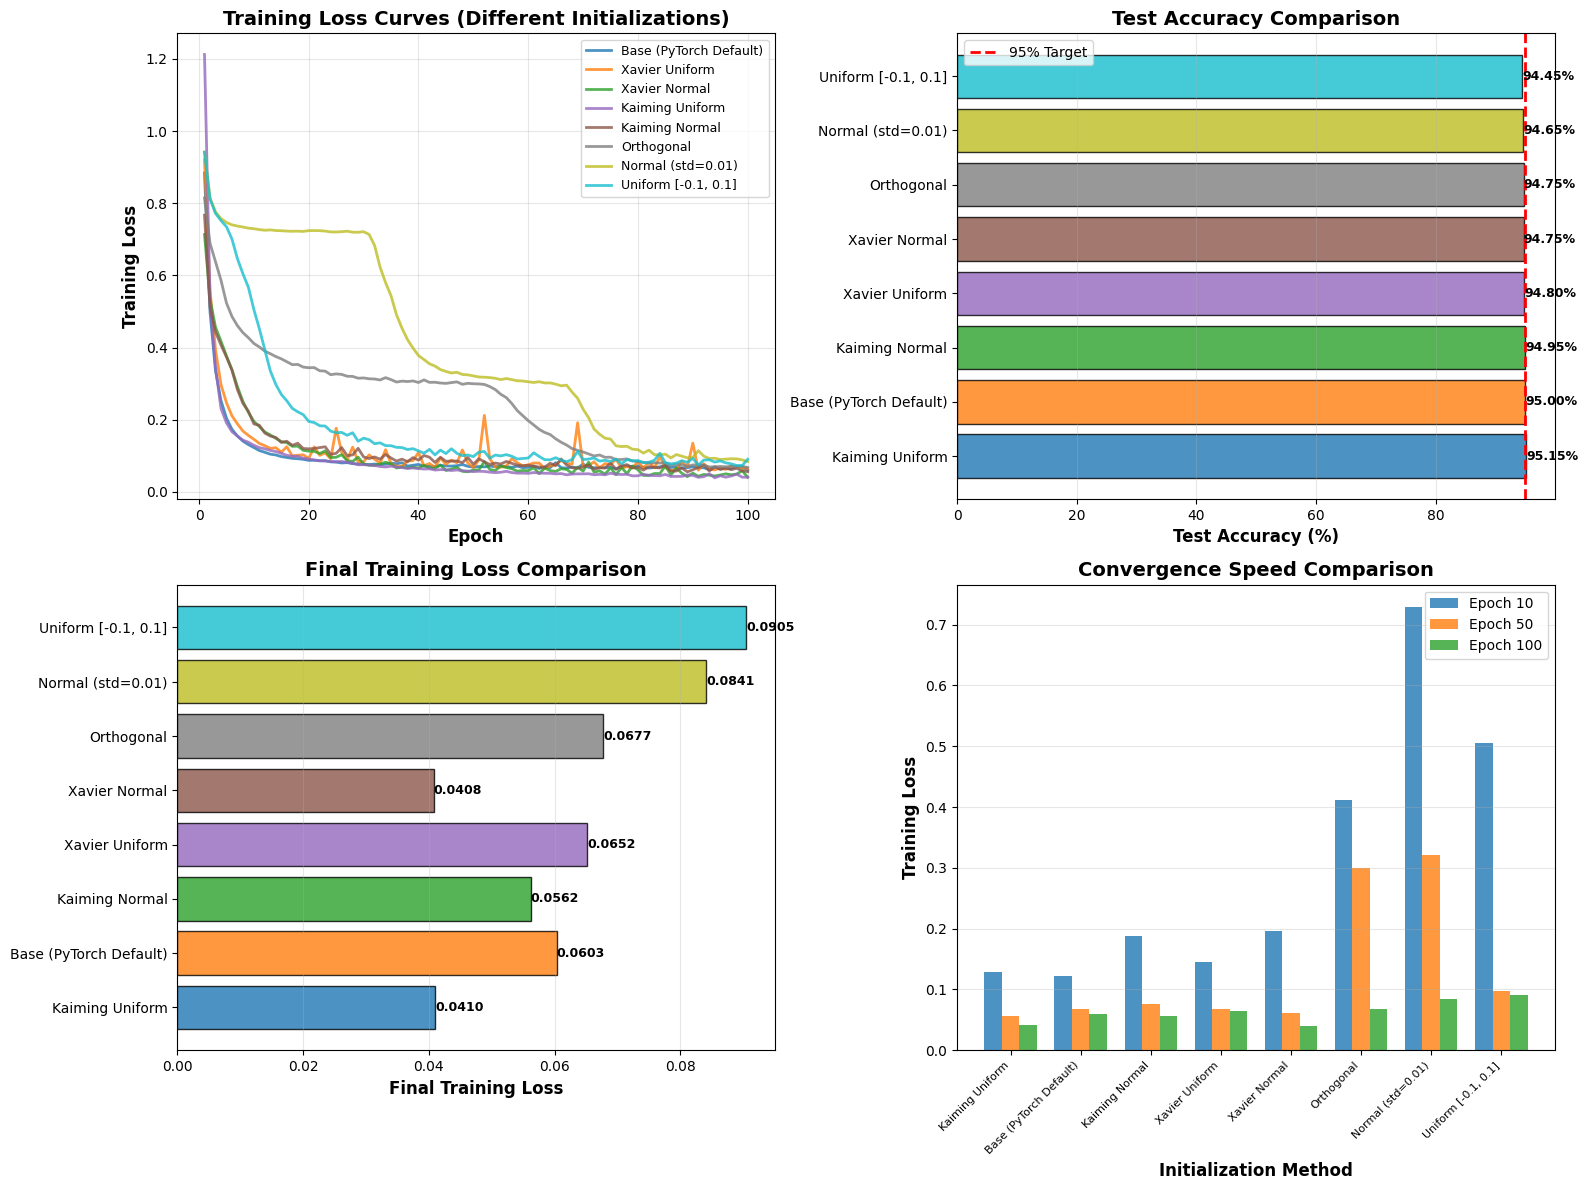


DETAILED DISCUSSION

1. KAIMING (HE) INITIALIZATION:
   - Designed specifically for ReLU activations
   - Maintains variance across layers
   - Expected to perform well with our ReLU network
   - Kaiming Uniform: 95.15%
   - Kaiming Normal: 94.95%

2. XAVIER (GLOROT) INITIALIZATION:
   - Designed for sigmoid/tanh activations
   - May not be optimal for ReLU networks
   - Xavier Uniform: 94.80%
   - Xavier Normal: 94.75%

3. ORTHOGONAL INITIALIZATION:
   - Preserves gradient norms
   - Good for deep networks
   - Orthogonal: 94.75%

4. SIMPLE INITIALIZATIONS:
   - May suffer from vanishing/exploding gradients
   - Normal (std=0.01): 94.65%
   - Uniform [-0.1, 0.1]: 94.45%




In [8]:
results = run_weight_initialization_experiment()